In [1]:
%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import json
import missingno as msno

In [2]:
data = pd.read_csv('./data/Eastern Front.csv')

In [3]:
data.shape

(186, 23)

In [4]:
data.dtypes

Belligerents.allies                   object
Belligerents.axis                     object
Belligerents.third party              object
Casualties and losses.allies          object
Casualties and losses.axis            object
Casualties and losses.third party     object
Casualties and losses.total           object
Commanders and leaders.allies         object
Commanders and leaders.axis           object
Commanders and leaders.third party    object
Date                                  object
Location                              object
Result                                object
Strength.allies                       object
Strength.axis                         object
Strength.third party                  object
Strength.total                        object
Territorial                           object
level                                  int64
name                                  object
parent                                object
time                                  object
url       

In [6]:
data.level.value_counts()

100    147
1       25
3       12
7        1
5        1
Name: level, dtype: int64

# Battles only

In [5]:
battles = data[data.level == 100]
battles.shape

(147, 23)

In [6]:
columns = ['Location', 'name', 'Date', 'Result', 'Belligerents.allies',
           'Belligerents.axis', 'Casualties and losses.allies', 'Casualties and losses.axis']

In [7]:
battles['Location'].iloc[15]

'Wilno, Second Polish Republic54°40′N 25°19′E\ufeff / \ufeff54.667°N 25.317°E\ufeff / 54.667; 25.317Coordinates: 54°40′N 25°19′E\ufeff / \ufeff54.667°N 25.317°E\ufeff / 54.667; 25.317'

In [8]:
battles[columns].head()

,Location,name,Date,Result,Belligerents.allies,Belligerents.axis,Casualties and losses.allies,Casualties and losses.axis
0,"Westerplatte, harbor of Free City of Danzig54°...",Battle of Westerplatte,1–7 September 1939,German victory,Poland,Germany Danzig,15-21 killed and missing 40-53 wounded Remaind...,300-400 casualties
1,"Mokra, Kielce Voivodeship, Poland",Battle of Mokra,"September 1, 1939",Polish victory,Germany,Poland,"800 killed, missing, captured, or wounded 50 t...","500 killed, missing or wounded 300 horses seve..."
2,"Near Mława, Warsaw Voivodeship, Poland",Battle of Mlawa,1–3 September 1939,German victory,Germany,Poland,"1,800 killed 3,000 wounded 1,000 missing 72 ta...","1,200 killed 1,500 wounded"
3,"Near Tuchola Forest, Pomeranian Voivodeship, P...",Battle of Tuchola Forest,1–5 September 1939,German victory,Germany,Poland,506 killed \n \n743 wounded,1600 killed\n 750 wounded\n \nUnknown number c...
4,"Jordanów, Kraków Voivodeship, Poland",Battle of Jordanów,1–3 September 1939,Pyrrhic German victory,Poland,Germany,3+ tanks,70+ tanks and AFVs


# Empty Cells

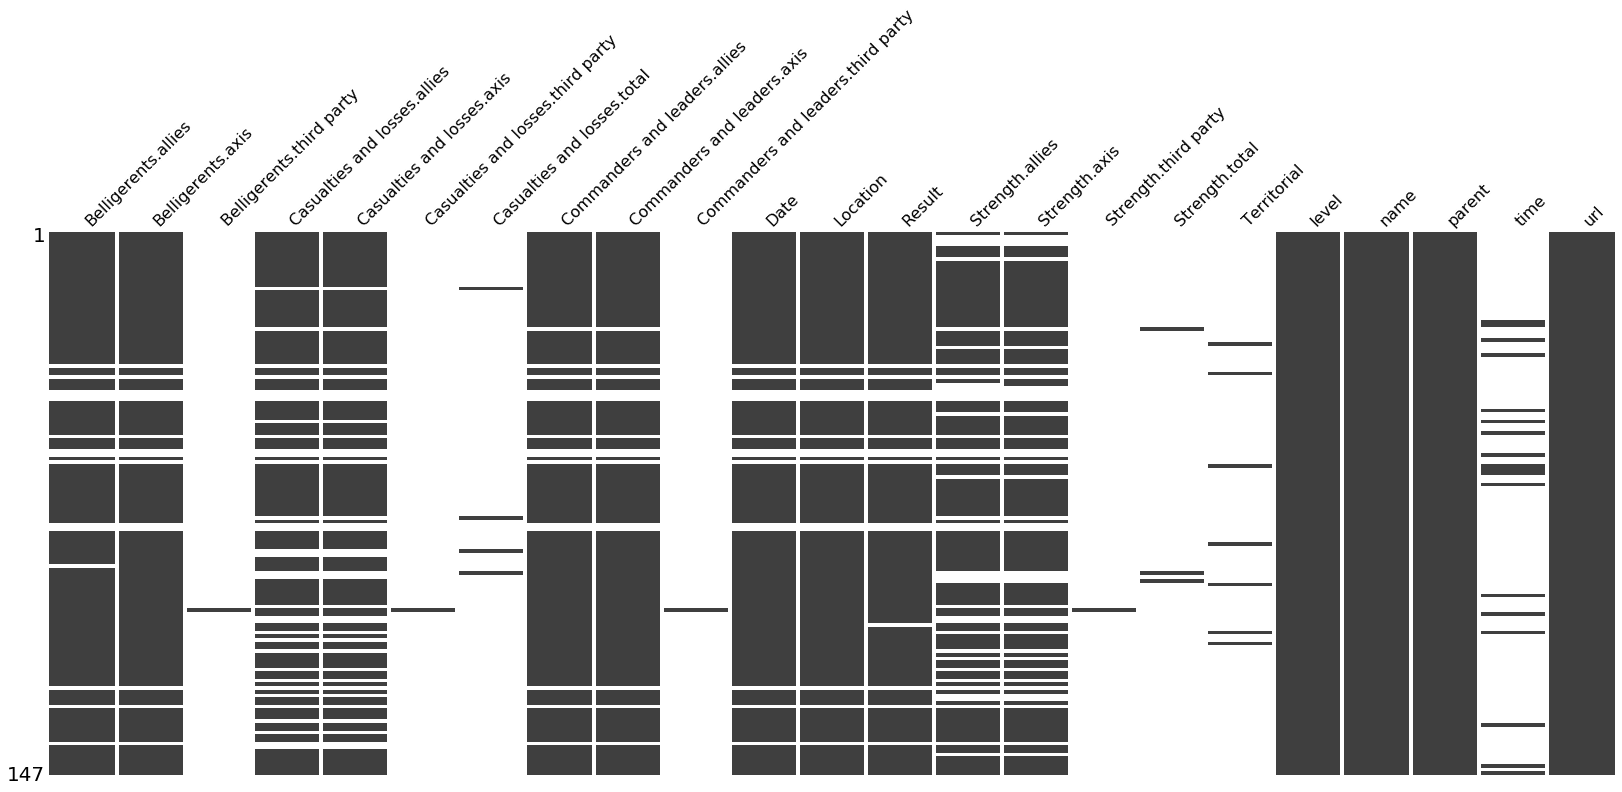

In [9]:
msno.matrix(battles, labels=True, sparkline=False)

In [10]:
mask = battles[['Date', 'Location']].isnull().all(1)

In [11]:
print(battles.loc[mask, ['name', 'url']].to_string())

                                    name                                                url
39   Pripyat swamps (punitive operation)  https://en.wikipedia.org/wiki/Pripyat_swamps_(...
42    Bombing of Tallinn in World War II  https://en.wikipedia.org/wiki/Bombing_of_Talli...
46                       Operation Wotan  https://en.wikipedia.org/w/index.php?title=Ope...
47                      Nevsky Pyatachok     https://en.wikipedia.org/wiki/Nevsky_Pyatachok
48            Operation Nordlicht (1942)  https://en.wikipedia.org/wiki/Operation_Nordli...
61                      Operation Büffel  https://en.wikipedia.org/wiki/Operation_B%C3%B...
67                     Operation Kremlin    https://en.wikipedia.org/wiki/Operation_Kremlin
68                Operation Braunschweig  https://en.wikipedia.org/wiki/Operation_Brauns...
70                         Malaya Zemlya        https://en.wikipedia.org/wiki/Malaya_Zemlya
96                   Concert (operation)  https://en.wikipedia.org/wiki/Concert_

In [12]:
battles.loc[mask, ['name', 'url']].iloc[3, 1]

'https://en.wikipedia.org/wiki/Nevsky_Pyatachok'

In [13]:
battles=battles.dropna(subset=['Date', 'Location'])

# Location

In [14]:
pattern = r'/ ([\d|\.]+); ([\d|\.]+)'

In [15]:
# battles.iloc[9]['Location']

In [16]:
battles[['Lattitude', 'Longitude']] = battles.Location.str.extract(pattern)

In [17]:
for col in  'Lattitude', 'Longitude':
    battles[col] =  battles[col].astype(float)

In [18]:
f"{(battles['Lattitude'].isnull().sum() / len(battles)):.1%}"

'75.9%'

# Geocode

So, we actually don't have coordinates for 78% of our battles, which is too hight. As an alternative, let's use the geocoding function we wrote in chapter 6! Of course, some addesses are obsolete, but most will, probably, get us to the coordinates

In [19]:
from geocode import nominatim_geocode # copied the file from folder "Chapter06"

In [20]:
from tqdm import tqdm, tqdm_notebook
tqdm().pandas()

0it [00:00, ?it/s]


In [21]:
geo_mask = battles['Lattitude'].isnull()

In [22]:
battles.loc[geo_mask, 'Location'].sample(15, random_state=2019)

19                        Wytyczno, near Włodawa, Poland
75         Rzhev and Velikie Luki salients, Russian SFSR
2                 Near Mława, Warsaw Voivodeship, Poland
128                                               Poland
7                           Piotrków Trybunalski, Poland
151                                 Belgrade, Yugoslavia
113                        Kerch Peninsula, Soviet Union
184                               Prague, Czechoslovakia
76                             Tatsinskaya, Soviet Union
132                       Western Ukraine/Eastern Poland
64                   Demyansk, Russian SSR, Soviet Union
27     Brest, Belarusian SSR, Soviet Union (Nominally...
25                                      Petsamo, Finland
183         Bautzen, Germany and surrounding rural areas
120                                      Belorussian SSR
Name: Location, dtype: object

In [23]:
location = battles['Location'].str.lower().str.replace('near ', '')

In [24]:
replacements = {
    'Ukrainian SSR, Soviet Union': 'Ukraine',
    'Russian SFSR, Soviet Union': 'Russia',
    'Russian SFSR': 'Russia',
    'Belorussian SSR': 'Belorus',
    'Soviet Union': '',
    'USSR': '',
    ', Poland (now Ukraine)': 'Ukraine',
    'east prussia (now kaliningrad oblast)': 'Kaliningrad Oblast, Russia',
    ', czechoslovakia': ', czech republic',
    'königsberg, germany (now: kaliningrad, russia)': 'Kaliningrad Oblast, Russia',
    'lwów, lwów voivodeship, poland': 'Lvov, Ukraine',
    'leningrad region, ; narva, estonia': 'Narva, Estonia',
    'Kingdom of Hungary': 'Hungary',
    'odessa region, ukraine': 'Odessa, Ukraine'
}

In [25]:
for k, v in replacements.items():
    location = location.str.replace(k.lower(), v.lower(), regex=False)

In [26]:
def vectorized_geocode(x):
    result = nominatim_geocode(x)
    if len(result) == 0:
        return dict()
    return {k:result[0][k] for k in ('lat', 'lon', 'importance', 'display_name')}

In [27]:
# nominatim_geocode('realm commissariat ostland\ngeneral district of latvia\nkreisgebiete liepaja\nkreise aizpute\nkreise kuldiga\nkreise liepaja\nkreise liepaja (city)\nkreise talsi\nkreise ventspils\nkreisgebiete jelgava\nkreise jelgava\nkreise tukums\ngeneral district of lithuania\nkreisgebiete siauliai\nkreise kretinga\nkreise mazeikiai'.replace('\n', ' '))

In [28]:
location[location.fillna('').str.contains('kreisgebiete')] = 'Courland Peninsula'

In [29]:
response = location[geo_mask].str.replace('\n', ' ').progress_apply(vectorized_geocode)

100%|██████████| 101/101 [02:09<00:00,  1.41s/it]


In [30]:
response.iloc[0]

{'lat': '50.85983',
 'lon': '20.576839',
 'importance': 0.5,
 'display_name': 'Mokra, Biesaki, Kielce, Świętokrzyskie Voivodeship, 25-707, Poland'}

In [31]:
battles.loc[geo_mask, 'Location'].iloc[0]

'Mokra, Kielce Voivodeship, Poland'

In [32]:
geo_df = pd.DataFrame(response.tolist(), index = response.index)
geo_df.rename(columns={'lat': 'Lattitude', 'lon': ' Longitude'}, inplace=True)

In [36]:
rmask = geo_df['importance'].isnull()  # still no location

In [37]:
f'{rmask.sum() / len(battles):.1%}'

'28.6%'

In [38]:
location[geo_mask].loc[rmask]

2                      mława, warsaw voivodeship, poland
4                   jordanów, kraków voivodeship, poland
6                                   wizna, łomża, poland
8          hel peninsula, pomeranian voivodeship, poland
18                                          szackukraine
19                             wytyczno, włodawa, poland
27     brest, belarusian ssr,  (nominally part of pol...
28              byelorussian soviet socialist republic, 
30                                    baltic countries, 
33                   finland, karelia, and murmansk area
35               petsamo, litsa river, rybachy peninsula
36              salla, kestenga, alakurtti, verman river
38                                 uman, western ukraine
49     southern shore of lake ladoga, present-day sin...
58                                rostov-on-don region, 
64                               demyansk, russian ssr, 
65        izium/barvenkovo area, kharkov oblast, ukraine
75               rzhev and veli

## Time

In [39]:
# pd.to_datetime('September 1939')

In [40]:
battles.loc[94, 'Date']

'3 November 1943 – 13 November 1943(Offensive operation) 13 November 1943 – 22 December 1943(Defensive operation)'

In [41]:
d = ('January', 'February', 'March', 'April', 'May', 
     'June', "July",' August', 'September', 'October', 'November', 'December')

month_pattern = r'(' + "|".join(d) + ')'

In [42]:
year_pattern = r'(19\d\d)'

In [43]:
year_extracted = battles['Date'].str.extractall(year_pattern).unstack()

In [44]:
# len(d.iloc[:, -1].notnull())
year_extracted[year_extracted.iloc[:, -1].notnull()]

0                  
match     0     1     2     3
94     1943  1943  1943  1943

In [45]:
# d[d.iloc[:, -1].notnull()]

In [46]:
battles.loc[94, 'Date']

'3 November 1943 – 13 November 1943(Offensive operation) 13 November 1943 – 22 December 1943(Defensive operation)'

In [47]:
year_extracted = year_extracted.iloc[:, :2]

In [48]:
year_extracted.head(10)

0     
match     0    1
0      1939  NaN
1      1939  NaN
2      1939  NaN
3      1939  NaN
4      1939  NaN
5      1939  NaN
6      1939  NaN
7      1939  NaN
8      1939  NaN
9      1939  NaN

In [49]:
year_extracted.iloc[:, 1] = year_extracted.iloc[:, 1].fillna(year_extracted.iloc[:, 0])

In [50]:
month_extracted = battles['Date'].str.extractall(month_pattern).unstack()

In [51]:
for i in range(2, month_extracted.shape[1]+1):
    month_extracted.iloc[:, -1].fillna(month_extracted.iloc[:, -i], inplace=True)

In [52]:
month_extracted = month_extracted.iloc[:, [0, -1]]

In [53]:
year_extracted.columns = month_extracted.columns = ['start', 'end']
I = battles.index
cols = 'start', 'end'

for col in cols:
    battles[col] = pd.to_datetime(month_extracted.loc[I, col] + ' ' + year_extracted.loc[I, col])

/Users/philippk/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


# Sides Swap

In [54]:
words = ['Germany', 'Italy', 'Estonian conscripts']

In [55]:
for word in words:
    mask = battles['Belligerents.allies'].fillna('').str.contains(word)
    axis_party = battles.loc[mask, ['Belligerents.allies', 'Casualties and losses.allies']].copy()
    battles.loc[mask, ['Belligerents.allies', 'Casualties and losses.allies']] = battles.loc[mask, ['Belligerents.axis', 'Casualties and losses.axis']].values
    battles.loc[mask, ['Belligerents.axis', 'Casualties and losses.axis']] = axis_party.values

## Casualties

In [56]:
battles['Casualties and losses.allies'].iloc[0]

'15-21 killed and missing 40-53 wounded Remainder captured'

In [57]:
digit_pattern = '([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:{words})'

keywords = { 'killed': ['men', 'dead', 'killed', 'casualties', 'kia'], 
             'wounded': ['wounded', 'sick', 'injured'], 
             'captured': ['captured', 'prisoners'],
             'tanks': ['tank', 'panzer'],
             'airplane': ['airplane', 'aircraft'],
             'guns': ['artillery', 'gun', 'self propelled guns', 'field-guns', 'anti-tank guns'],
             'ships': ['warships', 'boats', 'destroyer', 'minelayer'],
             'submarines': ['submarines']
}

only_digits = '([\d|\,|\.]+)\Z'

In [58]:
# column[column.fillna('').str.match(only_digits)].str.extract(only_digits)

In [59]:
def _shy_convert_numeric(v):
    if pd.isnull(v) or v in (',', '.'):
        return pd.np.nan
    
    return int(v.replace(',', '').replace('.', ''))
    

In [60]:
results = {
'allies' : pd.DataFrame(index=battles.index, columns=keywords.keys()),  # empty dataframes with the same index
'axis' : pd.DataFrame(index=battles.index, columns=keywords.keys())
}

for name, edf in results.items():
    column = battles[f'Casualties and losses.{name}']
    for tp, keys in keywords.items():
        pattern = digit_pattern.format(words="|".join(keys))
        print(pattern)
        extracted = column.str.lower().str.extractall(pattern).unstack()
        values = extracted.applymap(_shy_convert_numeric)
#         if tp == 'killed':
#             mask values.iloc[:, 0].notnull()
        edf[tp] = values.min(1)
    results[name] = edf.fillna(0).astype(int)
    

    b = column.fillna('').str.extract(only_digits).applymap(_shy_convert_numeric).iloc[:, 0]
    mask = b.notnull()
    results[name].loc[mask, 'killed'] = b[mask]

([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:wounded|sick|injured)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:captured|prisoners)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:tank|panzer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:airplane|aircraft)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:artillery|gun|self propelled guns|field-guns|anti-tank guns)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:warships|boats|destroyer|minelayer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:submarines)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:wounded|sick|injured)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:captured|prisoners)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:tank|panzer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:airplane|aircraft)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:artillery|gun|self propelled guns|field-guns|anti-tank guns)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:warships|boats|destroyer|minelayer)
([\d|\,|\.]+)(?:\[\d+\])?\+?\s*(?:submarines)


In [61]:
pattern = '([\d|\,]+)(?:\[\d+\])?\+?\s*(?:men|dead|killed|casualties|kia)'
battles[f'Casualties and losses.axis'].str.extractall(pattern).unstack().head(5)

0                    
match      0    1    2    3    4
0        400  NaN  NaN  NaN  NaN
1        800  NaN  NaN  NaN  NaN
2      1,800  NaN  NaN  NaN  NaN
3        506  NaN  NaN  NaN  NaN
5        650  NaN  NaN  NaN  NaN

In [76]:
battles['Casualties and losses.axis'][battles.name == 'Battle of Stalingrad'].iloc[0]

'647,300–768,374   Germany 300,000+ [8] [9] [10]   Italy 114,000 [11] –114,520 [12]   Romania 109,000 [11] –158,854 [12]   Hungary 105,000 [11] –143,000 [12] Hiwi  19,300–52,000 [13] \n 900 aircraft destroyed 1,500 tanks destroyed (100 Romanian) 6,000 guns destroyed 744 aircraft; 1,666 tanks; 5,762 guns captured \nSee  casualties section .'

In [72]:
# battles[battles.name == 'Battle of Stalingrad']

In [74]:
results['axis'][battles.name == 'Battle of Stalingrad']

,killed,wounded,captured,tanks,airplane,guns,ships,submarines
72,0.0,0,0,1500,744,5762,0,0


In [73]:
battles.loc[[27], 'Casualties and losses.axis'].iloc[0] #.str.extractall('([\d|\,]+)\s[tank]')

'429 dead, 668 wounded [4]'

In [74]:
results['axis'].loc[27]

killed        429.0
wounded       668.0
captured        0.0
tanks           0.0
airplane        0.0
guns            0.0
ships           0.0
submarines      0.0
Name: 27, dtype: float64

In [75]:
results['axis'][battles.name == 'Battle for Velikiye Luki (1943)']

,killed,wounded,captured,tanks,airplane,guns,ships,submarines
80,60000.0,0,4500,0,0,0,0,0


In [76]:
battles.loc[battles.name=='Battle for Velikiye Luki (1943)', 'Casualties and losses.axis'].iloc[0]

'Soviet estimate: ~60.000 killed, missing or wounded, 4.500 captured [3]'

# Combine

In [77]:
results['old_metrics'] = battles
new_dataset = pd.concat(results, axis=1)

# Quality Assurance

In [78]:
idx = pd.IndexSlice

In [116]:
assumptions = {
    'killed': [0, 2_000_000],
    'wounded': [0, 1_000_000],
    'tanks': [0, 5_000],
    'airplane': [0, 3_000],
    'guns': [0, 30_000],
    ('start', 'end'): [pd.to_datetime(el) for el in ('1939-01-01', '1945-12-31')]
}

In [132]:
def _check_assumptions(data, assumptions):
    for k, (min_, max_) in assumptions.items():
        df = data.loc[:, idx[:, k]]
        for i in range(df.shape[1]):
            assert df.iloc[:, i].between(min_, max_).all(), (df.iloc[:, i].name, df.iloc[:, i].describe())

In [130]:
d = new_dataset.loc[new_dataset.loc[:, idx['allies', 'tanks']] > 1_000 , idx['old_metrics', ['name', 'url']]] 
d

old_metrics  \
                          name   
28   Battle of Białystok-Minsk   
30            Baltic Operation   
37   Battle of Smolensk (1941)   
65    Second Battle of Kharkov   
72        Battle of Stalingrad   
75              Operation Mars   
87           Operation Kutuzov   
132  Lvov–Sandomierz Offensive   
162        Heiligenbeil Pocket   

                                                        
                                                   url  
28   https://en.wikipedia.org/wiki/Battle_of_Bia%C5...  
30      https://en.wikipedia.org/wiki/Baltic_Operation  
37   https://en.wikipedia.org/wiki/Battle_of_Smolen...  
65   https://en.wikipedia.org/wiki/Second_Battle_of...  
72   https://en.wikipedia.org/wiki/Battle_of_Stalin...  
75        https://en.wikipedia.org/wiki/Operation_Mars  
87     https://en.wikipedia.org/wiki/Operation_Kutuzov  
132  https://en.wikipedia.org/wiki/Lvov%E2%80%93San...  
162  https://en.wikipedia.org/wiki/Heiligenbeil_Pocket

In [131]:
d.iloc[0, 1]

'https://en.wikipedia.org/wiki/Battle_of_Bia%C5%82ystok-Minsk'

In [133]:
_check_assumptions(new_dataset, assumptions)

In [124]:
new_dataset.loc[~new_dataset.loc[:, idx['old_metrics', 'start']].between(*[pd.to_datetime(el) for el in ('1939-01-01', '1945-12-31')]), idx['old_metrics', ['start']]]

,old_metrics
,start
135,NaT


In [127]:
new_dataset.loc[new_dataset.loc[:, idx['old_metrics', 'start']].isnull(), idx['old_metrics', ['name','url']]]

old_metrics                                                   
                     name                                                url
135  Battle of Studzianki  https://en.wikipedia.org/wiki/Battle_of_Studzi...

In [129]:
new_dataset.loc[135, idx['old_metrics', 'start']] = pd.to_datetime('1944-08-09')
new_dataset.loc[135, idx['old_metrics', 'end']] = pd.to_datetime('1944-08-16') # August 9–16, 1944

In [134]:
_check_assumptions(new_dataset, assumptions)

# Store

In [135]:
new_dataset.to_csv('./data/EF_battles.csv', index=None)